In [1]:
import os
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from datetime import datetime

## Load Data

In [2]:
ground_truth = {}
texts = {}

In [3]:
with open('train/gold_labels.json') as f:
    for line in f.readlines():
        gold_json = json.loads(line)
        ground_truth[gold_json['id']] = gold_json['label']

In [4]:
for file in os.listdir('train/txts'):
    with open('train/txts/' + file) as f:
        texts[file.split('.')[0]] = f.read()

In [5]:
empty = set(texts.keys()) - set(ground_truth.keys()) 
print(f'Delete {len(empty)} texts')
for idx in empty:
    texts.pop(idx)

Delete 17 texts


In [6]:
N = len(texts)
print(N)

3989


## Date

In [17]:
count_first = 0
count_in = 0
count_last = 0
count_max_year = 0

max_accuracy = 0
for left in range(10, 500, 10):
    for right in range (10, 500, 10):
        count_max_year = 0
        for idx, text in texts.items():
            if ground_truth[idx]['date'] in re.findall(r'\d\d\.\d\d\.\d\d\d\d', text):
                count_in += 1
            dates = re.findall(r'\d\d\.\d\d\.\d\d\d\d', text)
            if dates and ground_truth[idx]['date'] == dates[0]:
                count_first += 1
            if len(dates) > 1 and ground_truth[idx]['date'] == dates[-1]:
                count_last += 1

            gold_year = int(ground_truth[idx]['date'].split('.')[-1])
            years = re.findall(r'201\d', text[:left] + text[-right:])
            years = set(map(int, years))
            if years and max(years) == gold_year:
                count_max_year += 1
            accuracy = count_max_year/N
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                max_left = left
                max_right = right
        print(f'[{left}][{right}] count_max_year: ', count_max_year/N)
        
print(f'max_accuracy: {max_accuracy}, left: {max_left}, right: {max_right}')
print('count_in: ', count_in/N)
print('count_first: ', count_first/N)
print('count_last: ', count_last/N)
print('count_max_year: ', count_max_year/N)

[10][10] count_max_year:  0.007771371270995237
[10][20] count_max_year:  0.19628979694158938
[10][30] count_max_year:  0.2479318124843319
[10][40] count_max_year:  0.27224868388067186
[10][50] count_max_year:  0.2857859112559539
[10][60] count_max_year:  0.2895462521935322
[10][70] count_max_year:  0.28804211581850087
[10][80] count_max_year:  0.2915517673602407
[10][90] count_max_year:  0.29280521433943346
[10][100] count_max_year:  0.29230383554775635
[10][110] count_max_year:  0.29180245675607924


KeyboardInterrupt: 

In [152]:
text_id = 'e722e991da9c35da785268aa0e9b470ef17823d1'
print(ground_truth[text_id])
print(texts[text_id])

{'name': 'О внесении изменений в статью 12.2 Закона Ставропольского края "Об административных правонарушениях в Ставропольском крае', 'number': '65-кз', 'authority': 'Дума Ставропольского края', 'date': '30.06.2015', 'type': 'закон'}
ЗАКОН

СТАВРОПОЛЬСКОГО!: КРАЯ

О внесении изменений в статью 12.2 Закона Ставропольского края
"Об административных правонарушениях в Ставропольском крае"

Статья 1

Внести в статью 12.2 Закона Ставропольского края от 10 апреля 2008 г.
№ 20-кз "Об административных правонарУШениях в Ставропольском крае" следующие изменения: - |
| 1) часть 2 дополнить пунктом 12 следующего содержания:

"12) должностные лица органов исполнительной власти Ставропольского
края, осуществляющие региональный государственный контроль (надзор), а также переданные органам исполнительной власти Ставропольского края полномочия в области федерального государственного надзора, - об административных
правонарушениях, предусмотренных частью 1 статьи 19.4, частью 1 статьи 19.4!,
частью 1 стат

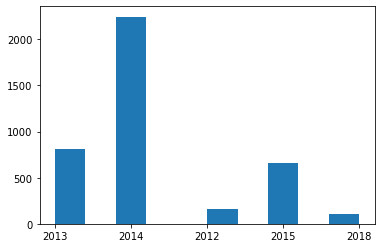

In [80]:
years = []
for label in ground_truth.values():
    years.append(label['date'].split('.')[-1])
plt.hist(years);

In [43]:
dates = []
for label in ground_truth.values():
    dates.append(datetime.strptime(label['date'], '%d.%m.%Y').date())
D = np.array(dates)
U, C = np.unique(D, return_counts=True)
c_max = np.argmax(C)
U[c_max]

datetime.date(2014, 12, 26)

In [7]:
def year2data(year, search_text):
    return len(re.findall(r'\d\d[а-я]{3,8}'+str(year), search_text) + \
               re.findall(r'\d\d\.\d\d\.'+str(year), search_text))

In [9]:
month_mapping = {
    'декабря': '12',
    'ноября': '11',
    'октября': '10',
    'сентября': '09',
    'августа': '08',
    'июля': '07',
    'июня': '06',
    'мая': '05',
    'апреля': '04',
    'марта': '03',
    'февраля': '02',
    'января': '01'
}

year_true_count = 0
date_true_count = 0
date = None

for idx, text in texts.items():
    #print(idx)

    text = text.lower().replace(' ', '')
    #split_text = text.split('\n')
    search_text = text[:140] + text[-60:]
    #search_text = '\n'.join(split_text[:8] + split_text[-5:])

    # gold data
    gold_year = int(ground_truth[idx]['date'].split('.')[-1])
    gold_date = ground_truth[idx]['date']
    
    # search max year
    years = set(re.findall(r'201\d', search_text))
    if not years:
        search_text = text
        years = set(re.findall(r'201\d', search_text))
    years = set(map(int, years))

    # drop years without data
    years_with_data = set()
    for year in years:
        if year2data(year, search_text):
            years_with_data.add(year)
    if years_with_data:
        year = max(years_with_data)
    else:
        year = max(years)
    
    # search date
    dates = re.findall(r'\d\d[а-я]{3,8}'+str(year), search_text)
    if dates:
        date = dates[-1]
        date = date[:2] + '.' + date[2:-4] + '.' + date[-4:]
        for month, number in month_mapping.items():
            date = date.replace(month, number)
    else:
        dates = re.findall(r'\d\d\.\d\d\.'+str(year), search_text)
        if dates:
            date = dates[0]
        else:
            date = '26.12.2014'
    
    if date == gold_date:
        date_true_count += 1
    print(date)
    #if year == gold_year:
    #    year_true_count += 1

#print('Year accuracy: ', year_true_count/N)
print('Date accuracy: ', date_true_count/N)

28.11.2013
24.12.2014
13.03.2014
26.04.2013
31.08.2015
25.12.2014
10.12.2014
29.10.2015
23.07.2013
19.11.2014
23.06.2014
25.11.2014
29.04.2015
19.03.2013
06.10.2014
12.11.2012
25.12.2012
12.06.2014
26.12.2014
30.12.2012
12.12.2014
12.03.2018
24.11.2014
17.12.2014
25.06.2015
27.06.2014
22.03.2014
06.03.2015
10.03.2015
21.11.2014
16.12.2014
23.05.2013
30.10.2013
30.05.2013
17.11.2014
24.06.2013
18.09.2014
15.08.2014
28.11.2014
23.12.2014
23.12.2014
15.12.2014
23.12.2015
22.01.2014
24.11.2014
30.04.2014
18.12.2015
21.12.2015
06.03.2015
01.09.2015
23.10.2014
25.10.2013
22.12.2014
16.12.2014
10.10.2014
27.03.2013
30.09.2013
27.11.2014
25.12.2014
30.10.2015
30.12.2014
26.04.2013
18.12.2014
30.10.2015
15.08.2014
28.11.2014
29.12.2014
19.11.2014
02.11.2015
11.02.2013
11.03.2015
11.03.2015
15.12.2015
18.12.2015
17.12.2015
29.06.2013
20.11.2014
10.10.2014
16.12.2014
21.06.2014
07.10.2014
25.07.2013
13.12.2012
10.12.2013
12.03.2015
11.12.2014
11.11.2014
11.01.2013
20.05.2014
21.12.2013
23.03.2013

08.07.2015
16.09.2013
14.10.2014
13.11.2013
12.03.2014
21.04.2013
18.12.2014
08.12.2014
18.12.2015
17.01.2014
30.04.2015
07.05.2015
29.04.2014
18.12.2015
18.04.2013
14.06.2012
23.12.2014
14.03.2018
25.11.2014
17.12.2015
17.12.2014
19.11.2014
24.12.2014
17.03.2014
13.12.2012
03.12.2014
06.07.2015
26.12.2013
31.12.2014
28.10.2015
20.09.2014
12.06.2013
18.12.2015
17.12.2014
16.10.2014
26.08.2014
14.03.2018
20.03.2014
16.04.2014
18.18.2014
10.12.2014
19.11.2014
20.11.2014
18.12.2015
22.12.2014
30.12.2014
23.08.2014
12.06.2012
31.08.2015
11.03.2015
23.07.2013
23.09.2014
30.12.2014
18.12.2014
25.11.2014
23.05.2013
06.03.2018
28.05.2014
30.07.2014
22.12.2014
26.12.2014
10.07.2014
28.10.2015
24.11.2014
09.12.2014
18.05.2013
03.11.2015
14.03.2014
26.12.2014
26.12.2014
04.03.2015
07.05.2015
31.08.2013
24.12.2013
23.07.2013
12.03.2015
30.12.2014
26.06.2015
29.03.2014
11.11.2013
25.05.2013
29.11.2012
19.12.2014
29.12.2014
25.12.2014
12.12.2014
22.04.2013
28.11.2014
28.10.2014
10.12.2014
21.12.2015

25.12.2014
21.07.2014
23.12.2014
12.10.2015
25.12.2014
19.03.2013
22.12.2014
28.06.2014
30.09.2013
05.05.2015
29.12.2014
20.04.2014
30.10.2015
26.11.2014
22.10.2014
30.04.2015
05.03.2015
21.07.2014
18.11.2014
30.10.2015
25.12.2014
25.04.2013
16.12.2014
18.03.2013
26.04.2013
22.04.2013
26.12.2014
15.08.2014
10.12.2014
26.12.2014
05.11.2014
21.08.2014
07.05.2015
27.05.2013
25.12.2012
15.04.2014
24.10.2013
26.12.2014
17.05.2014
18.12.2014
19.12.2015
19.03.2013
26.09.2014
16.10.2012
12.12.2014
05.03.2015
25.12.2012
31.05.2014
17.12.2015
28.04.2015
30.04.2015
02.11.2015
14.10.2012
22.12.2015
30.12.2012
10.11.2014
28.06.2014
30.09.2015
15.12.2015
12.12.2014
17.12.2015
Date accuracy:  0.9784407119578842


In [193]:
scores.argmax()-96*2

24

In [195]:
print(scores[2, 24])
print(np.arange(50, 800, 5)[2])
print(np.arange(20, 500, 5)[24])

0.9784407119578842
60
140


## CV

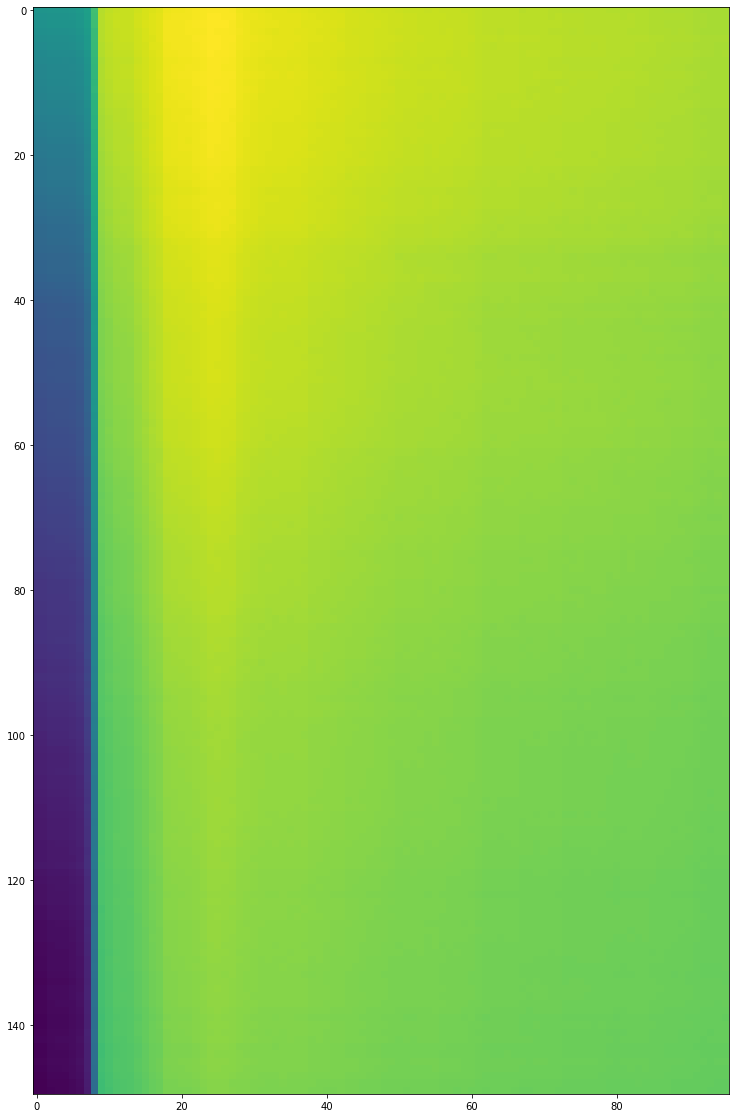

In [172]:
plt.figure(figsize=(20,20))
plt.imshow(scores)

In [171]:
month_mapping = {
    'декабря': '12',
    'ноября': '11',
    'октября': '10',
    'сентября': '09',
    'августа': '08',
    'июля': '07',
    'июня': '06',
    'мая': '05',
    'апреля': '04',
    'марта': '03',
    'февраля': '02',
    'января': '01'
}

def year2data(year, search_text):
    return len(re.findall(r'\d\d[а-я]{3,8}'+str(year), search_text) + \
               re.findall(r'\d\d\.\d\d\.'+str(year), search_text))

iteration = 0
date_true_count = 0
date = None
range_left = range(50, 800, 5)
range_right = range(20, 500, 5)
scores = np.zeros((len(range_left), len(range_right)))

for i, left in enumerate(range_left):
    for j, right in enumerate(range_right):
        date_true_count = 0
        for idx, text in texts.items():

            text = text.lower().replace(' ', '')
            search_text = text[:right] + text[-left:]

            # gold data
            gold_year = int(ground_truth[idx]['date'].split('.')[-1])
            gold_date = ground_truth[idx]['date']

            # search max year
            years = set(re.findall(r'201\d', search_text))
            if not years:
                search_text = text
                years = set(re.findall(r'201\d', search_text))
            years = set(map(int, years))

            # drop years without data
            years_with_data = set()
            for year in years:
                if year2data(year, search_text):
                    years_with_data.add(year)
            if years_with_data:
                year = max(years_with_data)
            else:
                year = max(years)

            # search date
            dates = re.findall(r'\d\d[а-я]{3,8}'+str(year), search_text)
            if dates:
                date = dates[-1]
                date = date[:2] + '.' + date[2:-4] + '.' + date[-4:]
                for month, number in month_mapping.items():
                    date = date.replace(month, number)
            else:
                dates = re.findall(r'\d\d\.\d\d\.'+str(year), search_text)
                if dates:
                    date = dates[0]
                else:
                    date = '26.12.2014'

            if date == gold_date:
                date_true_count += 1
    
        iteration += 1
        print('Progres: ', iteration/(len(range_left) * len(range_right)))
        scores[i, j] = date_true_count/N

Progres:  6.944444444444444e-05
Progres:  0.0001388888888888889
Progres:  0.00020833333333333335
Progres:  0.0002777777777777778
Progres:  0.00034722222222222224
Progres:  0.0004166666666666667
Progres:  0.0004861111111111111
Progres:  0.0005555555555555556
Progres:  0.000625
Progres:  0.0006944444444444445
Progres:  0.0007638888888888889
Progres:  0.0008333333333333334
Progres:  0.0009027777777777777
Progres:  0.0009722222222222222
Progres:  0.0010416666666666667
Progres:  0.0011111111111111111
Progres:  0.0011805555555555556
Progres:  0.00125
Progres:  0.0013194444444444445
Progres:  0.001388888888888889
Progres:  0.0014583333333333334
Progres:  0.0015277777777777779
Progres:  0.0015972222222222223
Progres:  0.0016666666666666668
Progres:  0.001736111111111111
Progres:  0.0018055555555555555
Progres:  0.001875
Progres:  0.0019444444444444444
Progres:  0.002013888888888889
Progres:  0.0020833333333333333
Progres:  0.0021527777777777778
Progres:  0.0022222222222222222
Progres:  0.00229

Progres:  0.01923611111111111
Progres:  0.019305555555555555
Progres:  0.019375
Progres:  0.019444444444444445
Progres:  0.01951388888888889
Progres:  0.019583333333333335
Progres:  0.01965277777777778
Progres:  0.01972222222222222
Progres:  0.019791666666666666
Progres:  0.01986111111111111
Progres:  0.019930555555555556
Progres:  0.02
Progres:  0.020069444444444445
Progres:  0.02013888888888889
Progres:  0.02020833333333333
Progres:  0.020277777777777777
Progres:  0.02034722222222222
Progres:  0.020416666666666666
Progres:  0.02048611111111111
Progres:  0.020555555555555556
Progres:  0.020625
Progres:  0.020694444444444446
Progres:  0.020763888888888887
Progres:  0.020833333333333332
Progres:  0.020902777777777777
Progres:  0.020972222222222222
Progres:  0.021041666666666667
Progres:  0.021111111111111112
Progres:  0.021180555555555557
Progres:  0.02125
Progres:  0.021319444444444443
Progres:  0.021388888888888888
Progres:  0.021458333333333333
Progres:  0.021527777777777778
Progres:

Progres:  0.03881944444444444
Progres:  0.03888888888888889
Progres:  0.03895833333333333
Progres:  0.03902777777777778
Progres:  0.03909722222222222
Progres:  0.03916666666666667
Progres:  0.03923611111111111
Progres:  0.03930555555555556
Progres:  0.039375
Progres:  0.03944444444444444
Progres:  0.03951388888888889
Progres:  0.03958333333333333
Progres:  0.03965277777777778
Progres:  0.03972222222222222
Progres:  0.03979166666666667
Progres:  0.03986111111111111
Progres:  0.03993055555555555
Progres:  0.04
Progres:  0.04006944444444444
Progres:  0.04013888888888889
Progres:  0.04020833333333333
Progres:  0.04027777777777778
Progres:  0.04034722222222222
Progres:  0.04041666666666666
Progres:  0.04048611111111111
Progres:  0.04055555555555555
Progres:  0.040625
Progres:  0.04069444444444444
Progres:  0.04076388888888889
Progres:  0.04083333333333333
Progres:  0.04090277777777778
Progres:  0.04097222222222222
Progres:  0.041041666666666664
Progres:  0.04111111111111111
Progres:  0.0411

Progres:  0.058541666666666665
Progres:  0.058611111111111114
Progres:  0.058680555555555555
Progres:  0.05875
Progres:  0.058819444444444445
Progres:  0.058888888888888886
Progres:  0.058958333333333335
Progres:  0.059027777777777776
Progres:  0.059097222222222225
Progres:  0.059166666666666666
Progres:  0.059236111111111114
Progres:  0.059305555555555556
Progres:  0.059375
Progres:  0.059444444444444446
Progres:  0.05951388888888889
Progres:  0.059583333333333335
Progres:  0.05965277777777778
Progres:  0.059722222222222225
Progres:  0.05979166666666667
Progres:  0.05986111111111111
Progres:  0.059930555555555556
Progres:  0.06
Progres:  0.060069444444444446
Progres:  0.06013888888888889
Progres:  0.060208333333333336
Progres:  0.06027777777777778
Progres:  0.06034722222222222
Progres:  0.06041666666666667
Progres:  0.06048611111111111
Progres:  0.06055555555555556
Progres:  0.060625
Progres:  0.06069444444444445
Progres:  0.06076388888888889
Progres:  0.060833333333333336
Progres:  0

Progres:  0.07847222222222222
Progres:  0.07854166666666666
Progres:  0.07861111111111112
Progres:  0.07868055555555556
Progres:  0.07875
Progres:  0.07881944444444444
Progres:  0.07888888888888888
Progres:  0.07895833333333334
Progres:  0.07902777777777778
Progres:  0.07909722222222222
Progres:  0.07916666666666666
Progres:  0.0792361111111111
Progres:  0.07930555555555556
Progres:  0.079375
Progres:  0.07944444444444444
Progres:  0.07951388888888888
Progres:  0.07958333333333334
Progres:  0.07965277777777778
Progres:  0.07972222222222222
Progres:  0.07979166666666666
Progres:  0.0798611111111111
Progres:  0.07993055555555556
Progres:  0.08
Progres:  0.08006944444444444
Progres:  0.08013888888888888
Progres:  0.08020833333333334
Progres:  0.08027777777777778
Progres:  0.08034722222222222
Progres:  0.08041666666666666
Progres:  0.0804861111111111
Progres:  0.08055555555555556
Progres:  0.080625
Progres:  0.08069444444444444
Progres:  0.08076388888888889
Progres:  0.08083333333333333
Pr

Progres:  0.09840277777777778
Progres:  0.09847222222222222
Progres:  0.09854166666666667
Progres:  0.09861111111111111
Progres:  0.09868055555555555
Progres:  0.09875
Progres:  0.09881944444444445
Progres:  0.09888888888888889
Progres:  0.09895833333333333
Progres:  0.09902777777777778
Progres:  0.09909722222222223
Progres:  0.09916666666666667
Progres:  0.09923611111111111
Progres:  0.09930555555555555
Progres:  0.099375
Progres:  0.09944444444444445
Progres:  0.09951388888888889
Progres:  0.09958333333333333
Progres:  0.09965277777777778
Progres:  0.09972222222222223
Progres:  0.09979166666666667
Progres:  0.09986111111111111
Progres:  0.09993055555555555
Progres:  0.1
Progres:  0.10006944444444445
Progres:  0.10013888888888889
Progres:  0.10020833333333333
Progres:  0.10027777777777777
Progres:  0.10034722222222223
Progres:  0.10041666666666667
Progres:  0.10048611111111111
Progres:  0.10055555555555555
Progres:  0.100625
Progres:  0.10069444444444445
Progres:  0.10076388888888889


Progres:  0.11840277777777777
Progres:  0.11847222222222223
Progres:  0.11854166666666667
Progres:  0.11861111111111111
Progres:  0.11868055555555555
Progres:  0.11875
Progres:  0.11881944444444445
Progres:  0.11888888888888889
Progres:  0.11895833333333333
Progres:  0.11902777777777777
Progres:  0.11909722222222222
Progres:  0.11916666666666667
Progres:  0.11923611111111111
Progres:  0.11930555555555555
Progres:  0.119375
Progres:  0.11944444444444445
Progres:  0.11951388888888889
Progres:  0.11958333333333333
Progres:  0.11965277777777777
Progres:  0.11972222222222222
Progres:  0.11979166666666667
Progres:  0.11986111111111111
Progres:  0.11993055555555555
Progres:  0.12
Progres:  0.12006944444444445
Progres:  0.12013888888888889
Progres:  0.12020833333333333
Progres:  0.12027777777777778
Progres:  0.12034722222222222
Progres:  0.12041666666666667
Progres:  0.12048611111111111
Progres:  0.12055555555555555
Progres:  0.120625
Progres:  0.12069444444444444
Progres:  0.12076388888888889

Progres:  0.1384027777777778
Progres:  0.13847222222222222
Progres:  0.13854166666666667
Progres:  0.1386111111111111
Progres:  0.13868055555555556
Progres:  0.13875
Progres:  0.13881944444444444
Progres:  0.1388888888888889
Progres:  0.13895833333333332
Progres:  0.13902777777777778
Progres:  0.13909722222222223
Progres:  0.13916666666666666
Progres:  0.13923611111111112
Progres:  0.13930555555555554
Progres:  0.139375
Progres:  0.13944444444444445
Progres:  0.13951388888888888
Progres:  0.13958333333333334
Progres:  0.13965277777777776
Progres:  0.13972222222222222
Progres:  0.13979166666666668
Progres:  0.1398611111111111
Progres:  0.13993055555555556
Progres:  0.14
Progres:  0.14006944444444444
Progres:  0.1401388888888889
Progres:  0.14020833333333332
Progres:  0.14027777777777778
Progres:  0.14034722222222223
Progres:  0.14041666666666666
Progres:  0.14048611111111112
Progres:  0.14055555555555554
Progres:  0.140625
Progres:  0.14069444444444446
Progres:  0.14076388888888888
Prog

Progres:  0.15840277777777778
Progres:  0.1584722222222222
Progres:  0.15854166666666666
Progres:  0.15861111111111112
Progres:  0.15868055555555555
Progres:  0.15875
Progres:  0.15881944444444446
Progres:  0.15888888888888889
Progres:  0.15895833333333334
Progres:  0.15902777777777777
Progres:  0.15909722222222222
Progres:  0.15916666666666668
Progres:  0.1592361111111111
Progres:  0.15930555555555556
Progres:  0.159375
Progres:  0.15944444444444444
Progres:  0.1595138888888889
Progres:  0.15958333333333333
Progres:  0.15965277777777778
Progres:  0.1597222222222222
Progres:  0.15979166666666667
Progres:  0.15986111111111112
Progres:  0.15993055555555555
Progres:  0.16
Progres:  0.16006944444444443
Progres:  0.1601388888888889
Progres:  0.16020833333333334
Progres:  0.16027777777777777
Progres:  0.16034722222222222
Progres:  0.16041666666666668
Progres:  0.1604861111111111
Progres:  0.16055555555555556
Progres:  0.160625
Progres:  0.16069444444444445
Progres:  0.1607638888888889
Progre

Progres:  0.17840277777777777
Progres:  0.17847222222222223
Progres:  0.17854166666666665
Progres:  0.1786111111111111
Progres:  0.17868055555555556
Progres:  0.17875
Progres:  0.17881944444444445
Progres:  0.17888888888888888
Progres:  0.17895833333333333
Progres:  0.17902777777777779
Progres:  0.1790972222222222
Progres:  0.17916666666666667
Progres:  0.17923611111111112
Progres:  0.17930555555555555
Progres:  0.179375
Progres:  0.17944444444444443
Progres:  0.1795138888888889
Progres:  0.17958333333333334
Progres:  0.17965277777777777
Progres:  0.17972222222222223
Progres:  0.17979166666666666
Progres:  0.1798611111111111
Progres:  0.17993055555555557
Progres:  0.18
Progres:  0.18006944444444445
Progres:  0.18013888888888888
Progres:  0.18020833333333333
Progres:  0.1802777777777778
Progres:  0.18034722222222221
Progres:  0.18041666666666667
Progres:  0.18048611111111112
Progres:  0.18055555555555555
Progres:  0.180625
Progres:  0.18069444444444444
Progres:  0.1807638888888889
Progr

Progres:  0.1984027777777778
Progres:  0.19847222222222222
Progres:  0.19854166666666667
Progres:  0.1986111111111111
Progres:  0.19868055555555555
Progres:  0.19875
Progres:  0.19881944444444444
Progres:  0.1988888888888889
Progres:  0.19895833333333332
Progres:  0.19902777777777778
Progres:  0.19909722222222223
Progres:  0.19916666666666666
Progres:  0.1992361111111111
Progres:  0.19930555555555557
Progres:  0.199375
Progres:  0.19944444444444445
Progres:  0.19951388888888888
Progres:  0.19958333333333333
Progres:  0.1996527777777778
Progres:  0.19972222222222222
Progres:  0.19979166666666667
Progres:  0.1998611111111111
Progres:  0.19993055555555556
Progres:  0.2
Progres:  0.20006944444444444
Progres:  0.2001388888888889
Progres:  0.20020833333333332
Progres:  0.20027777777777778
Progres:  0.20034722222222223
Progres:  0.20041666666666666
Progres:  0.20048611111111111
Progres:  0.20055555555555554
Progres:  0.200625
Progres:  0.20069444444444445
Progres:  0.20076388888888888
Progres

Progres:  0.21847222222222223
Progres:  0.21854166666666666
Progres:  0.21861111111111112
Progres:  0.21868055555555554
Progres:  0.21875
Progres:  0.21881944444444446
Progres:  0.21888888888888888
Progres:  0.21895833333333334
Progres:  0.21902777777777777
Progres:  0.21909722222222222
Progres:  0.21916666666666668
Progres:  0.2192361111111111
Progres:  0.21930555555555556
Progres:  0.219375
Progres:  0.21944444444444444
Progres:  0.2195138888888889
Progres:  0.21958333333333332
Progres:  0.21965277777777778
Progres:  0.21972222222222224
Progres:  0.21979166666666666
Progres:  0.21986111111111112
Progres:  0.21993055555555555
Progres:  0.22
Progres:  0.22006944444444446
Progres:  0.22013888888888888
Progres:  0.22020833333333334
Progres:  0.22027777777777777
Progres:  0.22034722222222222
Progres:  0.22041666666666668
Progres:  0.2204861111111111
Progres:  0.22055555555555556
Progres:  0.220625
Progres:  0.22069444444444444
Progres:  0.2207638888888889
Progres:  0.22083333333333333
Pro

Progres:  0.23854166666666668
Progres:  0.2386111111111111
Progres:  0.23868055555555556
Progres:  0.23875
Progres:  0.23881944444444445
Progres:  0.2388888888888889
Progres:  0.23895833333333333
Progres:  0.23902777777777778
Progres:  0.2390972222222222
Progres:  0.23916666666666667
Progres:  0.23923611111111112
Progres:  0.23930555555555555
Progres:  0.239375
Progres:  0.23944444444444443
Progres:  0.2395138888888889
Progres:  0.23958333333333334
Progres:  0.23965277777777777
Progres:  0.23972222222222223
Progres:  0.23979166666666665
Progres:  0.2398611111111111
Progres:  0.23993055555555556
Progres:  0.24
Progres:  0.24006944444444445
Progres:  0.2401388888888889
Progres:  0.24020833333333333
Progres:  0.24027777777777778
Progres:  0.2403472222222222
Progres:  0.24041666666666667
Progres:  0.24048611111111112
Progres:  0.24055555555555555
Progres:  0.240625
Progres:  0.24069444444444443
Progres:  0.2407638888888889
Progres:  0.24083333333333334
Progres:  0.24090277777777777
Progres

Progres:  0.2586111111111111
Progres:  0.2586805555555556
Progres:  0.25875
Progres:  0.25881944444444444
Progres:  0.2588888888888889
Progres:  0.25895833333333335
Progres:  0.2590277777777778
Progres:  0.2590972222222222
Progres:  0.25916666666666666
Progres:  0.2592361111111111
Progres:  0.25930555555555557
Progres:  0.259375
Progres:  0.2594444444444444
Progres:  0.2595138888888889
Progres:  0.25958333333333333
Progres:  0.2596527777777778
Progres:  0.25972222222222224
Progres:  0.25979166666666664
Progres:  0.2598611111111111
Progres:  0.25993055555555555
Progres:  0.26
Progres:  0.26006944444444446
Progres:  0.26013888888888886
Progres:  0.2602083333333333
Progres:  0.2602777777777778
Progres:  0.26034722222222223
Progres:  0.2604166666666667
Progres:  0.2604861111111111
Progres:  0.26055555555555554
Progres:  0.260625
Progres:  0.26069444444444445
Progres:  0.2607638888888889
Progres:  0.2608333333333333
Progres:  0.26090277777777776
Progres:  0.2609722222222222
Progres:  0.2610

Progres:  0.27881944444444445
Progres:  0.2788888888888889
Progres:  0.2789583333333333
Progres:  0.27902777777777776
Progres:  0.2790972222222222
Progres:  0.2791666666666667
Progres:  0.27923611111111113
Progres:  0.27930555555555553
Progres:  0.279375
Progres:  0.27944444444444444
Progres:  0.2795138888888889
Progres:  0.27958333333333335
Progres:  0.27965277777777775
Progres:  0.2797222222222222
Progres:  0.27979166666666666
Progres:  0.2798611111111111
Progres:  0.27993055555555557
Progres:  0.28
Progres:  0.2800694444444444
Progres:  0.2801388888888889
Progres:  0.28020833333333334
Progres:  0.2802777777777778
Progres:  0.28034722222222225
Progres:  0.28041666666666665
Progres:  0.2804861111111111
Progres:  0.28055555555555556
Progres:  0.280625
Progres:  0.28069444444444447
Progres:  0.28076388888888887
Progres:  0.2808333333333333
Progres:  0.2809027777777778
Progres:  0.28097222222222223
Progres:  0.2810416666666667
Progres:  0.2811111111111111
Progres:  0.28118055555555554
Pr

Progres:  0.29909722222222224
Progres:  0.2991666666666667
Progres:  0.2992361111111111
Progres:  0.29930555555555555
Progres:  0.299375
Progres:  0.29944444444444446
Progres:  0.2995138888888889
Progres:  0.2995833333333333
Progres:  0.29965277777777777
Progres:  0.2997222222222222
Progres:  0.2997916666666667
Progres:  0.29986111111111113
Progres:  0.29993055555555553
Progres:  0.3
Progres:  0.30006944444444444
Progres:  0.3001388888888889
Progres:  0.30020833333333335
Progres:  0.30027777777777775
Progres:  0.3003472222222222
Progres:  0.30041666666666667
Progres:  0.3004861111111111
Progres:  0.3005555555555556
Progres:  0.300625
Progres:  0.30069444444444443
Progres:  0.3007638888888889
Progres:  0.30083333333333334
Progres:  0.3009027777777778
Progres:  0.3009722222222222
Progres:  0.30104166666666665
Progres:  0.3011111111111111
Progres:  0.30118055555555556
Progres:  0.30125
Progres:  0.3013194444444444
Progres:  0.3013888888888889
Progres:  0.30145833333333333
Progres:  0.3015

Progres:  0.319375
Progres:  0.3194444444444444
Progres:  0.3195138888888889
Progres:  0.31958333333333333
Progres:  0.3196527777777778
Progres:  0.31972222222222224
Progres:  0.31979166666666664
Progres:  0.3198611111111111
Progres:  0.31993055555555555
Progres:  0.32
Progres:  0.32006944444444446
Progres:  0.32013888888888886
Progres:  0.3202083333333333
Progres:  0.3202777777777778
Progres:  0.3203472222222222
Progres:  0.3204166666666667
Progres:  0.32048611111111114
Progres:  0.32055555555555554
Progres:  0.320625
Progres:  0.32069444444444445
Progres:  0.3207638888888889
Progres:  0.32083333333333336
Progres:  0.32090277777777776
Progres:  0.3209722222222222
Progres:  0.32104166666666667
Progres:  0.3211111111111111
Progres:  0.3211805555555556
Progres:  0.32125
Progres:  0.32131944444444444
Progres:  0.3213888888888889
Progres:  0.32145833333333335
Progres:  0.3215277777777778
Progres:  0.3215972222222222
Progres:  0.32166666666666666
Progres:  0.3217361111111111
Progres:  0.321

Progres:  0.33958333333333335
Progres:  0.3396527777777778
Progres:  0.3397222222222222
Progres:  0.33979166666666666
Progres:  0.3398611111111111
Progres:  0.33993055555555557
Progres:  0.34
Progres:  0.3400694444444444
Progres:  0.3401388888888889
Progres:  0.34020833333333333
Progres:  0.3402777777777778
Progres:  0.34034722222222225
Progres:  0.34041666666666665
Progres:  0.3404861111111111
Progres:  0.34055555555555556
Progres:  0.340625
Progres:  0.34069444444444447
Progres:  0.34076388888888887
Progres:  0.3408333333333333
Progres:  0.3409027777777778
Progres:  0.34097222222222223
Progres:  0.3410416666666667
Progres:  0.3411111111111111
Progres:  0.34118055555555554
Progres:  0.34125
Progres:  0.34131944444444445
Progres:  0.3413888888888889
Progres:  0.3414583333333333
Progres:  0.34152777777777776
Progres:  0.3415972222222222
Progres:  0.3416666666666667
Progres:  0.34173611111111113
Progres:  0.34180555555555553
Progres:  0.341875
Progres:  0.34194444444444444
Progres:  0.34

Progres:  0.3597916666666667
Progres:  0.35986111111111113
Progres:  0.35993055555555553
Progres:  0.36
Progres:  0.36006944444444444
Progres:  0.3601388888888889
Progres:  0.36020833333333335
Progres:  0.36027777777777775
Progres:  0.3603472222222222
Progres:  0.36041666666666666
Progres:  0.3604861111111111
Progres:  0.3605555555555556
Progres:  0.360625
Progres:  0.36069444444444443
Progres:  0.3607638888888889
Progres:  0.36083333333333334
Progres:  0.3609027777777778
Progres:  0.36097222222222225
Progres:  0.36104166666666665
Progres:  0.3611111111111111
Progres:  0.36118055555555556
Progres:  0.36125
Progres:  0.36131944444444447
Progres:  0.36138888888888887
Progres:  0.3614583333333333
Progres:  0.3615277777777778
Progres:  0.36159722222222224
Progres:  0.3616666666666667
Progres:  0.3617361111111111
Progres:  0.36180555555555555
Progres:  0.361875
Progres:  0.36194444444444446
Progres:  0.3620138888888889
Progres:  0.3620833333333333
Progres:  0.36215277777777777
Progres:  0.3

Progres:  0.38
Progres:  0.38006944444444446
Progres:  0.3801388888888889
Progres:  0.3802083333333333
Progres:  0.38027777777777777
Progres:  0.3803472222222222
Progres:  0.3804166666666667
Progres:  0.38048611111111114
Progres:  0.38055555555555554
Progres:  0.380625
Progres:  0.38069444444444445
Progres:  0.3807638888888889
Progres:  0.38083333333333336
Progres:  0.38090277777777776
Progres:  0.3809722222222222
Progres:  0.38104166666666667
Progres:  0.3811111111111111
Progres:  0.3811805555555556
Progres:  0.38125
Progres:  0.38131944444444443
Progres:  0.3813888888888889
Progres:  0.38145833333333334
Progres:  0.3815277777777778
Progres:  0.3815972222222222
Progres:  0.38166666666666665
Progres:  0.3817361111111111
Progres:  0.38180555555555556
Progres:  0.381875
Progres:  0.3819444444444444
Progres:  0.3820138888888889
Progres:  0.38208333333333333
Progres:  0.3821527777777778
Progres:  0.38222222222222224
Progres:  0.38229166666666664
Progres:  0.3823611111111111
Progres:  0.382

Progres:  0.40020833333333333
Progres:  0.4002777777777778
Progres:  0.40034722222222224
Progres:  0.40041666666666664
Progres:  0.4004861111111111
Progres:  0.40055555555555555
Progres:  0.400625
Progres:  0.40069444444444446
Progres:  0.40076388888888886
Progres:  0.4008333333333333
Progres:  0.4009027777777778
Progres:  0.40097222222222223
Progres:  0.4010416666666667
Progres:  0.4011111111111111
Progres:  0.40118055555555554
Progres:  0.40125
Progres:  0.40131944444444445
Progres:  0.4013888888888889
Progres:  0.4014583333333333
Progres:  0.40152777777777776
Progres:  0.4015972222222222
Progres:  0.40166666666666667
Progres:  0.4017361111111111
Progres:  0.4018055555555556
Progres:  0.401875
Progres:  0.40194444444444444
Progres:  0.4020138888888889
Progres:  0.40208333333333335
Progres:  0.4021527777777778
Progres:  0.4022222222222222
Progres:  0.40229166666666666
Progres:  0.4023611111111111
Progres:  0.40243055555555557
Progres:  0.4025
Progres:  0.4025694444444444
Progres:  0.4

Progres:  0.42041666666666666
Progres:  0.4204861111111111
Progres:  0.42055555555555557
Progres:  0.420625
Progres:  0.4206944444444444
Progres:  0.4207638888888889
Progres:  0.42083333333333334
Progres:  0.4209027777777778
Progres:  0.42097222222222225
Progres:  0.42104166666666665
Progres:  0.4211111111111111
Progres:  0.42118055555555556
Progres:  0.42125
Progres:  0.42131944444444447
Progres:  0.42138888888888887
Progres:  0.4214583333333333
Progres:  0.4215277777777778
Progres:  0.42159722222222223
Progres:  0.4216666666666667
Progres:  0.4217361111111111
Progres:  0.42180555555555554
Progres:  0.421875
Progres:  0.42194444444444446
Progres:  0.4220138888888889
Progres:  0.4220833333333333
Progres:  0.42215277777777777
Progres:  0.4222222222222222
Progres:  0.4222916666666667
Progres:  0.42236111111111113
Progres:  0.42243055555555553
Progres:  0.4225
Progres:  0.42256944444444444
Progres:  0.4226388888888889
Progres:  0.42270833333333335
Progres:  0.42277777777777775
Progres:  0

Progres:  0.440625
Progres:  0.44069444444444444
Progres:  0.4407638888888889
Progres:  0.44083333333333335
Progres:  0.44090277777777775
Progres:  0.4409722222222222
Progres:  0.44104166666666667
Progres:  0.4411111111111111
Progres:  0.4411805555555556
Progres:  0.44125
Progres:  0.44131944444444443
Progres:  0.4413888888888889
Progres:  0.44145833333333334
Progres:  0.4415277777777778
Progres:  0.4415972222222222
Progres:  0.44166666666666665
Progres:  0.4417361111111111
Progres:  0.44180555555555556
Progres:  0.441875
Progres:  0.4419444444444444
Progres:  0.4420138888888889
Progres:  0.44208333333333333
Progres:  0.4421527777777778
Progres:  0.44222222222222224
Progres:  0.4422916666666667
Progres:  0.4423611111111111
Progres:  0.44243055555555555
Progres:  0.4425
Progres:  0.44256944444444446
Progres:  0.4426388888888889
Progres:  0.4427083333333333
Progres:  0.44277777777777777
Progres:  0.4428472222222222
Progres:  0.4429166666666667
Progres:  0.44298611111111114
Progres:  0.44

Progres:  0.4608333333333333
Progres:  0.4609027777777778
Progres:  0.4609722222222222
Progres:  0.4610416666666667
Progres:  0.46111111111111114
Progres:  0.46118055555555554
Progres:  0.46125
Progres:  0.46131944444444445
Progres:  0.4613888888888889
Progres:  0.46145833333333336
Progres:  0.46152777777777776
Progres:  0.4615972222222222
Progres:  0.46166666666666667
Progres:  0.4617361111111111
Progres:  0.4618055555555556
Progres:  0.461875
Progres:  0.46194444444444444
Progres:  0.4620138888888889
Progres:  0.46208333333333335
Progres:  0.4621527777777778
Progres:  0.4622222222222222
Progres:  0.46229166666666666
Progres:  0.4623611111111111
Progres:  0.46243055555555557
Progres:  0.4625
Progres:  0.4625694444444444
Progres:  0.4626388888888889
Progres:  0.46270833333333333
Progres:  0.4627777777777778
Progres:  0.46284722222222224
Progres:  0.46291666666666664
Progres:  0.4629861111111111
Progres:  0.46305555555555555
Progres:  0.463125
Progres:  0.46319444444444446
Progres:  0.4

Progres:  0.48104166666666665
Progres:  0.4811111111111111
Progres:  0.48118055555555556
Progres:  0.48125
Progres:  0.48131944444444447
Progres:  0.48138888888888887
Progres:  0.4814583333333333
Progres:  0.4815277777777778
Progres:  0.48159722222222223
Progres:  0.4816666666666667
Progres:  0.4817361111111111
Progres:  0.48180555555555554
Progres:  0.481875
Progres:  0.48194444444444445
Progres:  0.4820138888888889
Progres:  0.4820833333333333
Progres:  0.48215277777777776
Progres:  0.4822222222222222
Progres:  0.4822916666666667
Progres:  0.48236111111111113
Progres:  0.48243055555555553
Progres:  0.4825
Progres:  0.48256944444444444
Progres:  0.4826388888888889
Progres:  0.48270833333333335
Progres:  0.48277777777777775
Progres:  0.4828472222222222
Progres:  0.48291666666666666
Progres:  0.4829861111111111
Progres:  0.48305555555555557
Progres:  0.483125
Progres:  0.4831944444444444
Progres:  0.4832638888888889
Progres:  0.48333333333333334
Progres:  0.4834027777777778
Progres:  0.

Progres:  0.50125
Progres:  0.5013194444444444
Progres:  0.5013888888888889
Progres:  0.5014583333333333
Progres:  0.5015277777777778
Progres:  0.5015972222222222
Progres:  0.5016666666666667
Progres:  0.5017361111111112
Progres:  0.5018055555555555
Progres:  0.501875
Progres:  0.5019444444444444
Progres:  0.5020138888888889
Progres:  0.5020833333333333
Progres:  0.5021527777777778
Progres:  0.5022222222222222
Progres:  0.5022916666666667
Progres:  0.5023611111111111
Progres:  0.5024305555555556
Progres:  0.5025
Progres:  0.5025694444444444
Progres:  0.5026388888888889
Progres:  0.5027083333333333
Progres:  0.5027777777777778
Progres:  0.5028472222222222
Progres:  0.5029166666666667
Progres:  0.5029861111111111
Progres:  0.5030555555555556
Progres:  0.503125
Progres:  0.5031944444444445
Progres:  0.5032638888888888
Progres:  0.5033333333333333
Progres:  0.5034027777777778
Progres:  0.5034722222222222
Progres:  0.5035416666666667
Progres:  0.5036111111111111
Progres:  0.5036805555555556

Progres:  0.5217361111111111
Progres:  0.5218055555555555
Progres:  0.521875
Progres:  0.5219444444444444
Progres:  0.5220138888888889
Progres:  0.5220833333333333
Progres:  0.5221527777777778
Progres:  0.5222222222222223
Progres:  0.5222916666666667
Progres:  0.5223611111111112
Progres:  0.5224305555555555
Progres:  0.5225
Progres:  0.5225694444444444
Progres:  0.5226388888888889
Progres:  0.5227083333333333
Progres:  0.5227777777777778
Progres:  0.5228472222222222
Progres:  0.5229166666666667
Progres:  0.5229861111111112
Progres:  0.5230555555555556
Progres:  0.523125
Progres:  0.5231944444444444
Progres:  0.5232638888888889
Progres:  0.5233333333333333
Progres:  0.5234027777777778
Progres:  0.5234722222222222
Progres:  0.5235416666666667
Progres:  0.5236111111111111
Progres:  0.5236805555555556
Progres:  0.52375
Progres:  0.5238194444444444
Progres:  0.5238888888888888
Progres:  0.5239583333333333
Progres:  0.5240277777777778
Progres:  0.5240972222222222
Progres:  0.5241666666666667

Progres:  0.5422222222222223
Progres:  0.5422916666666666
Progres:  0.5423611111111111
Progres:  0.5424305555555555
Progres:  0.5425
Progres:  0.5425694444444444
Progres:  0.5426388888888889
Progres:  0.5427083333333333
Progres:  0.5427777777777778
Progres:  0.5428472222222223
Progres:  0.5429166666666667
Progres:  0.5429861111111111
Progres:  0.5430555555555555
Progres:  0.543125
Progres:  0.5431944444444444
Progres:  0.5432638888888889
Progres:  0.5433333333333333
Progres:  0.5434027777777778
Progres:  0.5434722222222222
Progres:  0.5435416666666667
Progres:  0.5436111111111112
Progres:  0.5436805555555555
Progres:  0.54375
Progres:  0.5438194444444444
Progres:  0.5438888888888889
Progres:  0.5439583333333333
Progres:  0.5440277777777778
Progres:  0.5440972222222222
Progres:  0.5441666666666667
Progres:  0.5442361111111111
Progres:  0.5443055555555556
Progres:  0.544375
Progres:  0.5444444444444444
Progres:  0.5445138888888889
Progres:  0.5445833333333333
Progres:  0.5446527777777778

Progres:  0.5627083333333334
Progres:  0.5627777777777778
Progres:  0.5628472222222223
Progres:  0.5629166666666666
Progres:  0.5629861111111111
Progres:  0.5630555555555555
Progres:  0.563125
Progres:  0.5631944444444444
Progres:  0.5632638888888889
Progres:  0.5633333333333334
Progres:  0.5634027777777778
Progres:  0.5634722222222223
Progres:  0.5635416666666667
Progres:  0.5636111111111111
Progres:  0.5636805555555555
Progres:  0.56375
Progres:  0.5638194444444444
Progres:  0.5638888888888889
Progres:  0.5639583333333333
Progres:  0.5640277777777778
Progres:  0.5640972222222222
Progres:  0.5641666666666667
Progres:  0.5642361111111112
Progres:  0.5643055555555555
Progres:  0.564375
Progres:  0.5644444444444444
Progres:  0.5645138888888889
Progres:  0.5645833333333333
Progres:  0.5646527777777778
Progres:  0.5647222222222222
Progres:  0.5647916666666667
Progres:  0.5648611111111111
Progres:  0.5649305555555556
Progres:  0.565
Progres:  0.5650694444444444
Progres:  0.5651388888888889


Progres:  0.5832638888888889
Progres:  0.5833333333333334
Progres:  0.5834027777777778
Progres:  0.5834722222222222
Progres:  0.5835416666666666
Progres:  0.5836111111111111
Progres:  0.5836805555555555
Progres:  0.58375
Progres:  0.5838194444444444
Progres:  0.5838888888888889
Progres:  0.5839583333333334
Progres:  0.5840277777777778
Progres:  0.5840972222222223
Progres:  0.5841666666666666
Progres:  0.5842361111111111
Progres:  0.5843055555555555
Progres:  0.584375
Progres:  0.5844444444444444
Progres:  0.5845138888888889
Progres:  0.5845833333333333
Progres:  0.5846527777777778
Progres:  0.5847222222222223
Progres:  0.5847916666666667
Progres:  0.5848611111111112
Progres:  0.5849305555555555
Progres:  0.585
Progres:  0.5850694444444444
Progres:  0.5851388888888889
Progres:  0.5852083333333333
Progres:  0.5852777777777778
Progres:  0.5853472222222222
Progres:  0.5854166666666667
Progres:  0.5854861111111112
Progres:  0.5855555555555556
Progres:  0.585625
Progres:  0.5856944444444444


Progres:  0.60375
Progres:  0.6038194444444445
Progres:  0.6038888888888889
Progres:  0.6039583333333334
Progres:  0.6040277777777778
Progres:  0.6040972222222222
Progres:  0.6041666666666666
Progres:  0.6042361111111111
Progres:  0.6043055555555555
Progres:  0.604375
Progres:  0.6044444444444445
Progres:  0.6045138888888889
Progres:  0.6045833333333334
Progres:  0.6046527777777778
Progres:  0.6047222222222223
Progres:  0.6047916666666666
Progres:  0.6048611111111111
Progres:  0.6049305555555555
Progres:  0.605
Progres:  0.6050694444444444
Progres:  0.6051388888888889
Progres:  0.6052083333333333
Progres:  0.6052777777777778
Progres:  0.6053472222222223
Progres:  0.6054166666666667
Progres:  0.6054861111111111
Progres:  0.6055555555555555
Progres:  0.605625
Progres:  0.6056944444444444
Progres:  0.6057638888888889
Progres:  0.6058333333333333
Progres:  0.6059027777777778
Progres:  0.6059722222222222
Progres:  0.6060416666666667
Progres:  0.6061111111111112
Progres:  0.6061805555555555


Progres:  0.6243055555555556
Progres:  0.624375
Progres:  0.6244444444444445
Progres:  0.6245138888888889
Progres:  0.6245833333333334
Progres:  0.6246527777777777
Progres:  0.6247222222222222
Progres:  0.6247916666666666
Progres:  0.6248611111111111
Progres:  0.6249305555555555
Progres:  0.625
Progres:  0.6250694444444445
Progres:  0.6251388888888889
Progres:  0.6252083333333334
Progres:  0.6252777777777778
Progres:  0.6253472222222223
Progres:  0.6254166666666666
Progres:  0.6254861111111111
Progres:  0.6255555555555555
Progres:  0.625625
Progres:  0.6256944444444444
Progres:  0.6257638888888889
Progres:  0.6258333333333334
Progres:  0.6259027777777778
Progres:  0.6259722222222223
Progres:  0.6260416666666667
Progres:  0.6261111111111111
Progres:  0.6261805555555555
Progres:  0.62625
Progres:  0.6263194444444444
Progres:  0.6263888888888889
Progres:  0.6264583333333333
Progres:  0.6265277777777778
Progres:  0.6265972222222222
Progres:  0.6266666666666667
Progres:  0.6267361111111112


Progres:  0.6447916666666667
Progres:  0.6448611111111111
Progres:  0.6449305555555556
Progres:  0.645
Progres:  0.6450694444444445
Progres:  0.6451388888888889
Progres:  0.6452083333333334
Progres:  0.6452777777777777
Progres:  0.6453472222222222
Progres:  0.6454166666666666
Progres:  0.6454861111111111
Progres:  0.6455555555555555
Progres:  0.645625
Progres:  0.6456944444444445
Progres:  0.6457638888888889
Progres:  0.6458333333333334
Progres:  0.6459027777777778
Progres:  0.6459722222222222
Progres:  0.6460416666666666
Progres:  0.6461111111111111
Progres:  0.6461805555555555
Progres:  0.64625
Progres:  0.6463194444444444
Progres:  0.6463888888888889
Progres:  0.6464583333333334
Progres:  0.6465277777777778
Progres:  0.6465972222222223
Progres:  0.6466666666666666
Progres:  0.6467361111111111
Progres:  0.6468055555555555
Progres:  0.646875
Progres:  0.6469444444444444
Progres:  0.6470138888888889
Progres:  0.6470833333333333
Progres:  0.6471527777777778
Progres:  0.6472222222222223


Progres:  0.6653472222222222
Progres:  0.6654166666666667
Progres:  0.6654861111111111
Progres:  0.6655555555555556
Progres:  0.665625
Progres:  0.6656944444444445
Progres:  0.6657638888888889
Progres:  0.6658333333333334
Progres:  0.6659027777777777
Progres:  0.6659722222222222
Progres:  0.6660416666666666
Progres:  0.6661111111111111
Progres:  0.6661805555555556
Progres:  0.66625
Progres:  0.6663194444444445
Progres:  0.6663888888888889
Progres:  0.6664583333333334
Progres:  0.6665277777777778
Progres:  0.6665972222222222
Progres:  0.6666666666666666
Progres:  0.6667361111111111
Progres:  0.6668055555555555
Progres:  0.666875
Progres:  0.6669444444444445
Progres:  0.6670138888888889
Progres:  0.6670833333333334
Progres:  0.6671527777777778
Progres:  0.6672222222222223
Progres:  0.6672916666666666
Progres:  0.6673611111111111
Progres:  0.6674305555555555
Progres:  0.6675
Progres:  0.6675694444444444
Progres:  0.6676388888888889
Progres:  0.6677083333333333
Progres:  0.6677777777777778

Progres:  0.6858333333333333
Progres:  0.6859027777777778
Progres:  0.6859722222222222
Progres:  0.6860416666666667
Progres:  0.6861111111111111
Progres:  0.6861805555555556
Progres:  0.68625
Progres:  0.6863194444444445
Progres:  0.6863888888888889
Progres:  0.6864583333333333
Progres:  0.6865277777777777
Progres:  0.6865972222222222
Progres:  0.6866666666666666
Progres:  0.6867361111111111
Progres:  0.6868055555555556
Progres:  0.686875
Progres:  0.6869444444444445
Progres:  0.6870138888888889
Progres:  0.6870833333333334
Progres:  0.6871527777777777
Progres:  0.6872222222222222
Progres:  0.6872916666666666
Progres:  0.6873611111111111
Progres:  0.6874305555555555
Progres:  0.6875
Progres:  0.6875694444444445
Progres:  0.6876388888888889
Progres:  0.6877083333333334
Progres:  0.6877777777777778
Progres:  0.6878472222222223
Progres:  0.6879166666666666
Progres:  0.6879861111111111
Progres:  0.6880555555555555
Progres:  0.688125
Progres:  0.6881944444444444
Progres:  0.6882638888888889

Progres:  0.7063194444444445
Progres:  0.7063888888888888
Progres:  0.7064583333333333
Progres:  0.7065277777777778
Progres:  0.7065972222222222
Progres:  0.7066666666666667
Progres:  0.7067361111111111
Progres:  0.7068055555555556
Progres:  0.706875
Progres:  0.7069444444444445
Progres:  0.7070138888888889
Progres:  0.7070833333333333
Progres:  0.7071527777777777
Progres:  0.7072222222222222
Progres:  0.7072916666666667
Progres:  0.7073611111111111
Progres:  0.7074305555555556
Progres:  0.7075
Progres:  0.7075694444444445
Progres:  0.7076388888888889
Progres:  0.7077083333333334
Progres:  0.7077777777777777
Progres:  0.7078472222222222
Progres:  0.7079166666666666
Progres:  0.7079861111111111
Progres:  0.7080555555555555
Progres:  0.708125
Progres:  0.7081944444444445
Progres:  0.7082638888888889
Progres:  0.7083333333333334
Progres:  0.7084027777777778
Progres:  0.7084722222222222
Progres:  0.7085416666666666
Progres:  0.7086111111111111
Progres:  0.7086805555555555
Progres:  0.70875

Progres:  0.7268055555555556
Progres:  0.726875
Progres:  0.7269444444444444
Progres:  0.7270138888888888
Progres:  0.7270833333333333
Progres:  0.7271527777777778
Progres:  0.7272222222222222
Progres:  0.7272916666666667
Progres:  0.7273611111111111
Progres:  0.7274305555555556
Progres:  0.7275
Progres:  0.7275694444444445
Progres:  0.7276388888888888
Progres:  0.7277083333333333
Progres:  0.7277777777777777
Progres:  0.7278472222222222
Progres:  0.7279166666666667
Progres:  0.7279861111111111
Progres:  0.7280555555555556
Progres:  0.728125
Progres:  0.7281944444444445
Progres:  0.7282638888888889
Progres:  0.7283333333333334
Progres:  0.7284027777777777
Progres:  0.7284722222222222
Progres:  0.7285416666666666
Progres:  0.7286111111111111
Progres:  0.7286805555555556
Progres:  0.72875
Progres:  0.7288194444444445
Progres:  0.7288888888888889
Progres:  0.7289583333333334
Progres:  0.7290277777777778
Progres:  0.7290972222222222
Progres:  0.7291666666666666
Progres:  0.7292361111111111

Progres:  0.7472916666666667
Progres:  0.7473611111111111
Progres:  0.7474305555555556
Progres:  0.7475
Progres:  0.7475694444444444
Progres:  0.7476388888888889
Progres:  0.7477083333333333
Progres:  0.7477777777777778
Progres:  0.7478472222222222
Progres:  0.7479166666666667
Progres:  0.7479861111111111
Progres:  0.7480555555555556
Progres:  0.748125
Progres:  0.7481944444444445
Progres:  0.7482638888888888
Progres:  0.7483333333333333
Progres:  0.7484027777777778
Progres:  0.7484722222222222
Progres:  0.7485416666666667
Progres:  0.7486111111111111
Progres:  0.7486805555555556
Progres:  0.74875
Progres:  0.7488194444444445
Progres:  0.7488888888888889
Progres:  0.7489583333333333
Progres:  0.7490277777777777
Progres:  0.7490972222222222
Progres:  0.7491666666666666
Progres:  0.7492361111111111
Progres:  0.7493055555555556
Progres:  0.749375
Progres:  0.7494444444444445
Progres:  0.7495138888888889
Progres:  0.7495833333333334
Progres:  0.7496527777777777
Progres:  0.7497222222222222

Progres:  0.7677777777777778
Progres:  0.7678472222222222
Progres:  0.7679166666666667
Progres:  0.7679861111111111
Progres:  0.7680555555555556
Progres:  0.768125
Progres:  0.7681944444444444
Progres:  0.7682638888888889
Progres:  0.7683333333333333
Progres:  0.7684027777777778
Progres:  0.7684722222222222
Progres:  0.7685416666666667
Progres:  0.7686111111111111
Progres:  0.7686805555555556
Progres:  0.76875
Progres:  0.7688194444444445
Progres:  0.7688888888888888
Progres:  0.7689583333333333
Progres:  0.7690277777777778
Progres:  0.7690972222222222
Progres:  0.7691666666666667
Progres:  0.7692361111111111
Progres:  0.7693055555555556
Progres:  0.769375
Progres:  0.7694444444444445
Progres:  0.7695138888888889
Progres:  0.7695833333333333
Progres:  0.7696527777777777
Progres:  0.7697222222222222
Progres:  0.7697916666666667
Progres:  0.7698611111111111
Progres:  0.7699305555555556
Progres:  0.77
Progres:  0.7700694444444445
Progres:  0.7701388888888889
Progres:  0.7702083333333334
P

Progres:  0.7882638888888889
Progres:  0.7883333333333333
Progres:  0.7884027777777778
Progres:  0.7884722222222222
Progres:  0.7885416666666667
Progres:  0.7886111111111112
Progres:  0.7886805555555556
Progres:  0.78875
Progres:  0.7888194444444444
Progres:  0.7888888888888889
Progres:  0.7889583333333333
Progres:  0.7890277777777778
Progres:  0.7890972222222222
Progres:  0.7891666666666667
Progres:  0.7892361111111111
Progres:  0.7893055555555556
Progres:  0.789375
Progres:  0.7894444444444444
Progres:  0.7895138888888888
Progres:  0.7895833333333333
Progres:  0.7896527777777778
Progres:  0.7897222222222222
Progres:  0.7897916666666667
Progres:  0.7898611111111111
Progres:  0.7899305555555556
Progres:  0.79
Progres:  0.7900694444444445
Progres:  0.7901388888888888
Progres:  0.7902083333333333
Progres:  0.7902777777777777
Progres:  0.7903472222222222
Progres:  0.7904166666666667
Progres:  0.7904861111111111
Progres:  0.7905555555555556
Progres:  0.790625
Progres:  0.7906944444444445
P

Progres:  0.80875
Progres:  0.8088194444444444
Progres:  0.8088888888888889
Progres:  0.8089583333333333
Progres:  0.8090277777777778
Progres:  0.8090972222222222
Progres:  0.8091666666666667
Progres:  0.8092361111111112
Progres:  0.8093055555555555
Progres:  0.809375
Progres:  0.8094444444444444
Progres:  0.8095138888888889
Progres:  0.8095833333333333
Progres:  0.8096527777777778
Progres:  0.8097222222222222
Progres:  0.8097916666666667
Progres:  0.8098611111111111
Progres:  0.8099305555555556
Progres:  0.81
Progres:  0.8100694444444444
Progres:  0.8101388888888889
Progres:  0.8102083333333333
Progres:  0.8102777777777778
Progres:  0.8103472222222222
Progres:  0.8104166666666667
Progres:  0.8104861111111111
Progres:  0.8105555555555556
Progres:  0.810625
Progres:  0.8106944444444445
Progres:  0.8107638888888888
Progres:  0.8108333333333333
Progres:  0.8109027777777778
Progres:  0.8109722222222222
Progres:  0.8110416666666667
Progres:  0.8111111111111111
Progres:  0.8111805555555556
P

Progres:  0.8293055555555555
Progres:  0.829375
Progres:  0.8294444444444444
Progres:  0.8295138888888889
Progres:  0.8295833333333333
Progres:  0.8296527777777778
Progres:  0.8297222222222222
Progres:  0.8297916666666667
Progres:  0.8298611111111112
Progres:  0.8299305555555555
Progres:  0.83
Progres:  0.8300694444444444
Progres:  0.8301388888888889
Progres:  0.8302083333333333
Progres:  0.8302777777777778
Progres:  0.8303472222222222
Progres:  0.8304166666666667
Progres:  0.8304861111111111
Progres:  0.8305555555555556
Progres:  0.830625
Progres:  0.8306944444444444
Progres:  0.8307638888888889
Progres:  0.8308333333333333
Progres:  0.8309027777777778
Progres:  0.8309722222222222
Progres:  0.8310416666666667
Progres:  0.8311111111111111
Progres:  0.8311805555555556
Progres:  0.83125
Progres:  0.8313194444444445
Progres:  0.8313888888888888
Progres:  0.8314583333333333
Progres:  0.8315277777777778
Progres:  0.8315972222222222
Progres:  0.8316666666666667
Progres:  0.8317361111111111
P

Progres:  0.8497916666666666
Progres:  0.8498611111111111
Progres:  0.8499305555555555
Progres:  0.85
Progres:  0.8500694444444444
Progres:  0.8501388888888889
Progres:  0.8502083333333333
Progres:  0.8502777777777778
Progres:  0.8503472222222223
Progres:  0.8504166666666667
Progres:  0.8504861111111112
Progres:  0.8505555555555555
Progres:  0.850625
Progres:  0.8506944444444444
Progres:  0.8507638888888889
Progres:  0.8508333333333333
Progres:  0.8509027777777778
Progres:  0.8509722222222222
Progres:  0.8510416666666667
Progres:  0.8511111111111112
Progres:  0.8511805555555556
Progres:  0.85125
Progres:  0.8513194444444444
Progres:  0.8513888888888889
Progres:  0.8514583333333333
Progres:  0.8515277777777778
Progres:  0.8515972222222222
Progres:  0.8516666666666667
Progres:  0.8517361111111111
Progres:  0.8518055555555556
Progres:  0.851875
Progres:  0.8519444444444444
Progres:  0.8520138888888888
Progres:  0.8520833333333333
Progres:  0.8521527777777778
Progres:  0.8522222222222222
P

Progres:  0.8703472222222223
Progres:  0.8704166666666666
Progres:  0.8704861111111111
Progres:  0.8705555555555555
Progres:  0.870625
Progres:  0.8706944444444444
Progres:  0.8707638888888889
Progres:  0.8708333333333333
Progres:  0.8709027777777778
Progres:  0.8709722222222223
Progres:  0.8710416666666667
Progres:  0.8711111111111111
Progres:  0.8711805555555555
Progres:  0.87125
Progres:  0.8713194444444444
Progres:  0.8713888888888889
Progres:  0.8714583333333333
Progres:  0.8715277777777778
Progres:  0.8715972222222222
Progres:  0.8716666666666667
Progres:  0.8717361111111112
Progres:  0.8718055555555555
Progres:  0.871875
Progres:  0.8719444444444444
Progres:  0.8720138888888889
Progres:  0.8720833333333333
Progres:  0.8721527777777778
Progres:  0.8722222222222222
Progres:  0.8722916666666667
Progres:  0.8723611111111111
Progres:  0.8724305555555556
Progres:  0.8725
Progres:  0.8725694444444444
Progres:  0.8726388888888889
Progres:  0.8727083333333333
Progres:  0.8727777777777778

Progres:  0.8908333333333334
Progres:  0.8909027777777778
Progres:  0.8909722222222223
Progres:  0.8910416666666666
Progres:  0.8911111111111111
Progres:  0.8911805555555555
Progres:  0.89125
Progres:  0.8913194444444444
Progres:  0.8913888888888889
Progres:  0.8914583333333334
Progres:  0.8915277777777778
Progres:  0.8915972222222223
Progres:  0.8916666666666667
Progres:  0.8917361111111111
Progres:  0.8918055555555555
Progres:  0.891875
Progres:  0.8919444444444444
Progres:  0.8920138888888889
Progres:  0.8920833333333333
Progres:  0.8921527777777778
Progres:  0.8922222222222222
Progres:  0.8922916666666667
Progres:  0.8923611111111112
Progres:  0.8924305555555555
Progres:  0.8925
Progres:  0.8925694444444444
Progres:  0.8926388888888889
Progres:  0.8927083333333333
Progres:  0.8927777777777778
Progres:  0.8928472222222222
Progres:  0.8929166666666667
Progres:  0.8929861111111111
Progres:  0.8930555555555556
Progres:  0.893125
Progres:  0.8931944444444444
Progres:  0.8932638888888889

Progres:  0.9113194444444445
Progres:  0.9113888888888889
Progres:  0.9114583333333334
Progres:  0.9115277777777778
Progres:  0.9115972222222222
Progres:  0.9116666666666666
Progres:  0.9117361111111111
Progres:  0.9118055555555555
Progres:  0.911875
Progres:  0.9119444444444444
Progres:  0.9120138888888889
Progres:  0.9120833333333334
Progres:  0.9121527777777778
Progres:  0.9122222222222223
Progres:  0.9122916666666666
Progres:  0.9123611111111111
Progres:  0.9124305555555555
Progres:  0.9125
Progres:  0.9125694444444444
Progres:  0.9126388888888889
Progres:  0.9127083333333333
Progres:  0.9127777777777778
Progres:  0.9128472222222223
Progres:  0.9129166666666667
Progres:  0.9129861111111112
Progres:  0.9130555555555555
Progres:  0.913125
Progres:  0.9131944444444444
Progres:  0.9132638888888889
Progres:  0.9133333333333333
Progres:  0.9134027777777778
Progres:  0.9134722222222222
Progres:  0.9135416666666667
Progres:  0.9136111111111112
Progres:  0.9136805555555556
Progres:  0.91375

Progres:  0.9318055555555556
Progres:  0.931875
Progres:  0.9319444444444445
Progres:  0.9320138888888889
Progres:  0.9320833333333334
Progres:  0.9321527777777778
Progres:  0.9322222222222222
Progres:  0.9322916666666666
Progres:  0.9323611111111111
Progres:  0.9324305555555555
Progres:  0.9325
Progres:  0.9325694444444445
Progres:  0.9326388888888889
Progres:  0.9327083333333334
Progres:  0.9327777777777778
Progres:  0.9328472222222223
Progres:  0.9329166666666666
Progres:  0.9329861111111111
Progres:  0.9330555555555555
Progres:  0.933125
Progres:  0.9331944444444444
Progres:  0.9332638888888889
Progres:  0.9333333333333333
Progres:  0.9334027777777778
Progres:  0.9334722222222223
Progres:  0.9335416666666667
Progres:  0.9336111111111111
Progres:  0.9336805555555555
Progres:  0.93375
Progres:  0.9338194444444444
Progres:  0.9338888888888889
Progres:  0.9339583333333333
Progres:  0.9340277777777778
Progres:  0.9340972222222222
Progres:  0.9341666666666667
Progres:  0.9342361111111112

Progres:  0.9522916666666666
Progres:  0.9523611111111111
Progres:  0.9524305555555556
Progres:  0.9525
Progres:  0.9525694444444445
Progres:  0.9526388888888889
Progres:  0.9527083333333334
Progres:  0.9527777777777777
Progres:  0.9528472222222222
Progres:  0.9529166666666666
Progres:  0.9529861111111111
Progres:  0.9530555555555555
Progres:  0.953125
Progres:  0.9531944444444445
Progres:  0.9532638888888889
Progres:  0.9533333333333334
Progres:  0.9534027777777778
Progres:  0.9534722222222223
Progres:  0.9535416666666666
Progres:  0.9536111111111111
Progres:  0.9536805555555555
Progres:  0.95375
Progres:  0.9538194444444444
Progres:  0.9538888888888889
Progres:  0.9539583333333334
Progres:  0.9540277777777778
Progres:  0.9540972222222223
Progres:  0.9541666666666667
Progres:  0.9542361111111111
Progres:  0.9543055555555555
Progres:  0.954375
Progres:  0.9544444444444444
Progres:  0.9545138888888889
Progres:  0.9545833333333333
Progres:  0.9546527777777778
Progres:  0.9547222222222222

Progres:  0.9727777777777777
Progres:  0.9728472222222222
Progres:  0.9729166666666667
Progres:  0.9729861111111111
Progres:  0.9730555555555556
Progres:  0.973125
Progres:  0.9731944444444445
Progres:  0.9732638888888889
Progres:  0.9733333333333334
Progres:  0.9734027777777777
Progres:  0.9734722222222222
Progres:  0.9735416666666666
Progres:  0.9736111111111111
Progres:  0.9736805555555555
Progres:  0.97375
Progres:  0.9738194444444445
Progres:  0.9738888888888889
Progres:  0.9739583333333334
Progres:  0.9740277777777778
Progres:  0.9740972222222222
Progres:  0.9741666666666666
Progres:  0.9742361111111111
Progres:  0.9743055555555555
Progres:  0.974375
Progres:  0.9744444444444444
Progres:  0.9745138888888889
Progres:  0.9745833333333334
Progres:  0.9746527777777778
Progres:  0.9747222222222223
Progres:  0.9747916666666666
Progres:  0.9748611111111111
Progres:  0.9749305555555555
Progres:  0.975
Progres:  0.9750694444444444
Progres:  0.9751388888888889
Progres:  0.9752083333333333


Progres:  0.9932638888888888
Progres:  0.9933333333333333
Progres:  0.9934027777777777
Progres:  0.9934722222222222
Progres:  0.9935416666666667
Progres:  0.9936111111111111
Progres:  0.9936805555555556
Progres:  0.99375
Progres:  0.9938194444444445
Progres:  0.9938888888888889
Progres:  0.9939583333333334
Progres:  0.9940277777777777
Progres:  0.9940972222222222
Progres:  0.9941666666666666
Progres:  0.9942361111111111
Progres:  0.9943055555555556
Progres:  0.994375
Progres:  0.9944444444444445
Progres:  0.9945138888888889
Progres:  0.9945833333333334
Progres:  0.9946527777777778
Progres:  0.9947222222222222
Progres:  0.9947916666666666
Progres:  0.9948611111111111
Progres:  0.9949305555555555
Progres:  0.995
Progres:  0.9950694444444445
Progres:  0.9951388888888889
Progres:  0.9952083333333334
Progres:  0.9952777777777778
Progres:  0.9953472222222223
Progres:  0.9954166666666666
Progres:  0.9954861111111111
Progres:  0.9955555555555555
Progres:  0.995625
Progres:  0.9956944444444444
